In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

#Dataset

In [2]:
def pendulum_dynamics(x, u, params):  # Compute the function f(x,t) such that theta'' = f(x,t)
  theta, omega = x
  m, l, g = params["m"], params["l"], params["g"]
  u = float(u)

  d_theta = omega
  d_omega = (g/l) * np.sin(theta) + u/(m * l**2)

  return np.array([d_theta, d_omega])

def rk4_step(f, x, u, dt, params):  # Compute the position after a short time dt based on the pervious position using rk4 method
  k1 = f(x, u, params)
  k2 = f(x + 0.5 * dt * k1, u, params)
  k3 = f(x + 0.5 * dt * k2, u, params)
  k4 = f(x + dt * k3, u, params)

  return x + (dt / 6) * (k1 + 2*k2 + 2*k3 + k4)

def trajectory_simulation(x0, u_control, dt, T, params):
  N = int(T/dt)
  x = np.zeros((N+1, 2))
  x[0] = x0

  for t in range(N):
    x[t+1] = rk4_step(pendulum_dynamics, x[t], u_control[t], dt, params)
  return x

In [11]:
#--------------
# Parameters
#--------------

params = {
    "g": 9.81,   # gravity (m/s^2)
    "l": 1.0,    # lenght (m)
    "m": 1.0     # mass (kg)
}

T = 10  # = 10s
dt = 0.005  # 2000 step
n_traj = 7  #  14 000 points

#------------
# Storage
#------------

X = []
traj_IDs = []
theta = []
omega = []

#-------------------
# Data generation
#-------------------

for k in range(n_traj):
  theta0 = np.random.uniform(-2*np.pi, 2*np.pi)  #random initialisation of the angle
  omega0 = np.random.uniform(-10.0, 10.0)      #random initialisation of the angular velocity
  u_traj = np.zeros((int(T/dt), 1))
  x0 = np.array([theta0, omega0])

  traj = trajectory_simulation(x0, u_traj, dt, T, params)
  traj = traj[:-1]

  X.append(traj) # We don't include the last one because there is no future state to predict
  traj_IDs.append( k * np.ones(int(T/dt), dtype=int) )

X = np.concatenate(X, axis=0)
traj_IDs = np.concatenate(traj_IDs)

print(X.shape)
print(traj_IDs.shape)

#------------
#   Save
#------------

np.savez(
         "2.1_HNN_dataset.npz",
         X=X,   # shape (N * (T / dt),2)
         traj_ID=traj_IDs,   # shape (N * (T / dt), 1)
         dt=dt
         )

/tmp/ipython-input-1061426118.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u = float(u)


(14000, 2)
(14000,)


In [12]:
data = np.load("2.1_HNN_dataset.npz")

print("Available keys:", data.files)  # Lists all keys in the archive
traj_IDs = data["traj_ID"]
unique_traj = np.unique(traj_IDs)

np.random.seed(42)
np.random.shuffle(unique_traj)

n_train = int(0.8 * len(unique_traj))
train_traj = unique_traj[:n_train]  # training dataset contain 80% of all the data
test_traj = unique_traj[n_train:]   # test dataset contain 20% of all the data

train_idx = np.isin(traj_IDs, train_traj)
test_idx = np.isin(traj_IDs, test_traj)

np.savez(
    "splits_HNN.npz",
    train_idx=train_idx,
    test_idx=test_idx
)   # Contain the IDs of the test trajectory and of the train trajectory


Available keys: ['X', 'traj_ID', 'dt']


(14000, 2)
(14000, 2)


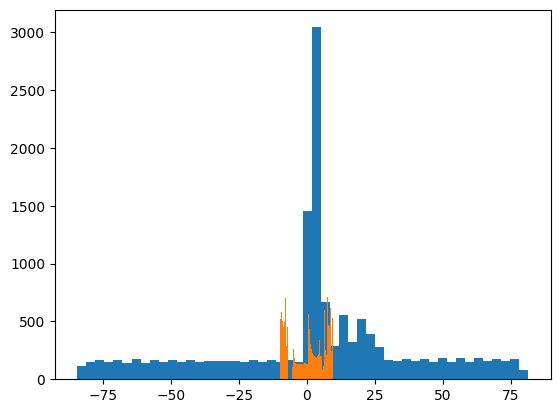

In [13]:
#--------------
# Parameters
#--------------

params = {
    "g": 9.81,   # gravity (m/s^2)
    "l": 1.0,    # lenght (m)
    "m": 1.0     # mass (kg)
}
#-------------
# Dataset
#-------------

data = np.load("2.1_HNN_dataset.npz")
split = np.load("splits_HNN.npz")

X = np.hstack([data["X"]])
Y = np.array([X[:,1], -(params["g"]/params["l"])*np.sin(X[:,0])]).T

X_train = X[split["train_idx"]]
Y_train = Y[split["train_idx"]]

X_test = X[split["test_idx"]]
Y_test = Y[split["test_idx"]]

print(X.shape)
print(Y.shape)
plt.hist(X[:,0],bins = 50)
plt.hist(X[:,1],bins = 50)


X_ = np.concatenate(X, axis=0)
Y_ = np.concatenate(Y, axis=0)

#--------
# Save
#--------
np.savez(
         "HNN_dataset.npz",
         X=X_,   # shape (N * (T / dt),2)
         traj_ID=traj_IDs,   # shape (N * (T / dt), 1)
         dt=dt,
         Y=Y_    # shape (N * (T / dt),2)
         )

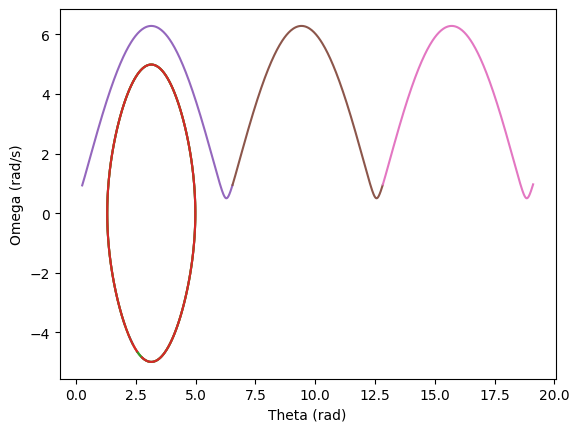

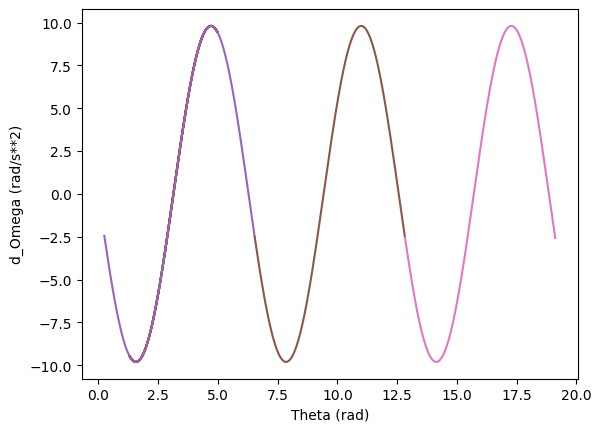

In [14]:
for k in range(7):
  plt.plot(X[k*500:(k+1)*500,0], X[k*500:(k+1)*500,1])
  plt.xlabel("Theta (rad)")
  plt.ylabel("Omega (rad/s)")

plt.figure()
for k in range(7):
  plt.plot(X[k*500:(k+1)*500,0], Y[k*500:(k+1)*500,1])
  plt.xlabel("Theta (rad)")
  plt.ylabel("d_Omega (rad/s**2)")